# Gather data
This also shows the code used to turn the COSMO-GHG output into total vertical columns. Due to file size constraints, we only share the total vertical columns as resulting from the following cell.

In [1]:
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d # Different interface to the same function
from scipy.interpolate import splprep, splev, interp2d, NearestNDInterpolator, LinearNDInterpolator
from matplotlib.path import Path
from collections import Counter
from tqdm.notebook import trange, tqdm

# # --- The data was gathered from the COSMO-GHG output as follows
# def convert_to_kg_m3(ds, trace_gas):
#     R_air=287.058
#     rho_moist = ds.P/(R_air*ds.T*(1+0.608*ds.QV))
#     return ds[trace_gas] * rho_moist

# def generate_fluxes(ds, ds0, Z, trace_gas, mode='Cartesian', return_winds=False):
#     '''
#     Compute the flux vector
#     '''
#     # --- Get the density field [level, rlat, rlon]
#     density = convert_to_kg_m3(ds, trace_gas)[0] # there is just one 'time'
    
#     # --- Obtain the depth levels for a numerical integration
#     Z = ((ds0.HHL[0][:-1]+ds0.HHL[0][1:])/2).rename({'level1': 'level'}) # Mid levels
#     dz = -ds0.HHL[0].diff(dim='level1').rename({'level1': 'level'}) # Vertical size of each level

#     # --- Get the total vertical column density: TVCD = \int_0^T \rho(x,y,z) * dz
#     TVCD = (density*dz).sum(dim="level")
    
#     # --- Get the concentration field
#     C0 =  (density)/(TVCD)# Obtain the normalized concentration profile C_0 = \rho / (\int\rho*dz) s.t. integration over z gives \int C_0 dz = 1.
    
#     # --- Fix staggered grid properties of the wind field
#     U = (ds.U[0]).interp(srlon=ds.rlon)
#     V = (ds.V[0]).interp(srlat=ds.rlat)
    
#     # --- Compute the effective wind
#     R = 6375000.0 # Earth radius
#     if mode=='Cartesian':
#         U0 = (U * C0 * dz ).sum(dim="level")
#         V0 = (V * C0 * dz ).sum(dim="level")
#     elif mode=='Spherical':
#         U0 = (U * C0 * (R+Z) * dz ).sum(dim="level")
#         V0 = (V * C0 * (R+Z) * dz * np.cos(np.deg2rad(ds.rlat)) ).sum(dim="level")
#     elif mode=="SphericalAlt":
#         U0 = (U * C0 * dz ).sum(dim="level")
#         V0 = (V * C0 * dz * np.cos(np.deg2rad(ds.rlat)) ).sum(dim="level")
#         U0 = R*U0
#         V0 = R*V0
        
#     # --- Fix missing values
#     Fx = (TVCD*U0).assign_coords({'time': ds.time[0]})
#     Fy = (TVCD*V0).assign_coords({'time': ds.time[0]})
#     TVCD_spherical = (density*dz*(R+Z)**2).sum(dim="level").assign_coords({'time': ds.time[0]})
#     if return_winds:
#         return Fx, Fy, U0, V0, TVCD, TVCD_spherical
#     else:
#         return Fx, Fy

# # --- Load in all files to memory    
# cosmo_files = sorted(glob('/home/erik-koene/project/coco2/jupyter/WP4/output/empa/20180605_03/*'))
# nfiles = len(cosmo_files)

# with xr.open_dataset('~/project/coco2/jupyter/WP4/output/empa/20180605_03/lffd20180605000000c.nc') as f0:
#     Z = (f0.HHL[0][:-1]+f0.HHL[0][1:])/2

# # --- Load first file
# fnumber = 16
# with xr.open_dataset(cosmo_files[fnumber]) as f1:
#     Fx, Fy, _, _, _ , TVCD = generate_fluxes(f1, f0, Z, 'CO2_PP_M', mode='Spherical', return_winds=True)
#     F = Fx.to_dataset(name='Fx')
#     F['Fy'] = Fy

# # --- Repeat for all other files
# for i, _ in enumerate(tqdm(cosmo_files[0:])):
#     if i<=fnumber: # Skip times before 3:45, as simulation is still spinning up then.
#         continue
#     with xr.open_dataset(cosmo_files[i]) as f1:    
#         Fx_n, Fy_n, _, _, _ , TVCD_n = generate_fluxes(f1, f0, Z, 'CO2_PP_M', mode='Spherical', return_winds=True)
#         TVCD = xr.concat([TVCD, TVCD_n], dim='time')
#         F_n = Fx_n.to_dataset(name='Fx')
#         F_n['Fy'] = Fy_n
#         F = xr.concat([F, F_n], dim='time')
# TVCD.to_dataset(name='TVCD').to_netcdf('~/project/coco2/jupyter/WP4/output/all_TVCD.nc')
# F.to_netcdf('~/project/coco2/jupyter/WP4/output/full_fluxes.nc')
    

# Load data from file (modify path appropriately)

In [2]:
TVCD = xr.open_dataset('~/project/coco2/jupyter/WP4/output/full_TVCD.nc').TVCD
F = xr.open_dataset('~/project/coco2/jupyter/WP4/output/full_fluxes.nc')

# Prepare data for all TVCDs
(takes ~50 minutes on this system)

In [3]:
import warnings
warnings.filterwarnings("ignore")

def return_closed_curve(pts, k=1, npts=1000):
    '''
    Compute x and y coordinates for a closed curve, given points in pts
    k=1 gives a linear interpolation, k=3 a cubic spline (=smoother).
    pts_i = x_i, y_i; i.e., pts=2xN array of 2D points.
    The output is regularly spaced in Euclidean space (i.e. dx^2+dy^2 is constant).
    Based on https://stackoverflow.com/a/31466013/4591046
    '''
    tck, u = splprep(pts.T, u=None, s=0.0, per=1, k=k)
    u_new = np.linspace(u.min(), u.max(), npts)
    x, y = splev(u_new, tck, der=0)
    return x, y

def NNintp(Xgrid, Ygrid, Zgrid, xpts, ypts, method='NN'):
    '''
    Do a nearest neighbour interpolation of Z(X,Y) on an, in principle, unstructured grid.
    Xgrid_{i,j} = Xgrid(i,j), 2D array of X coordinates
    Ygrid_{i,j} = Ygrid(i,j), 2D array of Y coordinates
    Zgrid_{i,j} = Z(Xgrid_{i,j}, Ygrid_{i,j}), array of ordinates
    xpts_i = array of x coordinates interpolated to
    ypts_i = array of y coordinates interpolated to
    '''
    if method == 'NN':
        Z_itp = NearestNDInterpolator(list(zip(Xgrid.ravel(), Ygrid.ravel())), Zgrid.ravel())
    elif method == 'linear':
        Z_itp = LinearNDInterpolator(list(zip(Xgrid.ravel(), Ygrid.ravel())), Zgrid.ravel())
    else:
        print('Unknown method, should be "NN" or "linear"')
        return 0
    return np.squeeze([Z_itp(x, y) for x, y in zip(xpts, ypts)])


def line_integral(Vx, Vy, x, y):
    '''
    Compute the line integral of a 2D vector-valued function [Vx, Vy].T
    multiplied with an outward pointing normal 'n', on a Cartesian grid.
    \oint V . n dS = \oint (Vx*dy - Vy*dx)
    
    Vx_i = Vx(x_i,y_i)
    Vy_i = Vy(x_i,y_i)
    x_i = array of x_coordinates
    y_i = array of y_coordinates    
    '''
    dx_f = np.diff(x)
    dy_f = np.diff(y)
    Vx_avg = (Vx[1:] + Vx[:-1])/2
    Vy_avg = (Vy[1:] + Vy[:-1])/2
    return (Vx_avg * dy_f - Vy_avg * dx_f).sum()

def create_mask(X, Y, x, y):
    '''
    Create a matrix mask based on a polygon mask defined on an unstructured grid
    based, but modified to allow unstructured grids, on
    https://stackoverflow.com/a/51208705/4591046
    '''
    width, height=X.shape
    polygon = list(zip(x, y))
    poly_path=Path(polygon)
    coors=np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1)))
    mask = poly_path.contains_points(coors).reshape(width, height)
    return mask

def half_mask_at_edges(mask, axis=0):
    '''
    This function takes a mask, e.g., for axis=1 (horizontal)
    mask = [[0  0  0  0  0],
            [0  1  1  1  0],
            [0  1  1  0  0],
            [0  0  1  0  0],
            [0  0  0  0  0]]
    and converts it to
    mask0= [[0  0  0  0  0],
            [0 .5  1 .5  0],
            [0 .5  .5 0  0],
            [0  0  1  0  0], <- note this special case!
            [0  0  0  0  0]]
    which is a required pre-conditioning step before supplying the masked data to
    a trapz integration, because the integration boundaries should only account 
    for '1/2' the amount of their dx/dy values.
    '''
    mask0 = mask.astype(float)      # Deal with the mask in floating point fashion

    x0 = np.arange(mask0.shape[0])  # Create array with x indices
    y0 = np.arange(mask0.shape[1])  # Create array with y indices

    if axis==0:
        locsX = x0[:-1, np.newaxis]+1/2 + np.diff(mask0*1, axis=0)/2
        difX = np.where(locsX*10%10==0, locsX.astype(int), 0)
        XX = [loc for loc in difX.flatten() if loc!=0]
        XY = np.nonzero(difX)[1]
        # Deduplicate items
        Xcoords = list(zip(XX, XY))
        nits = Counter(Xcoords)
        Xcoords = [k for k, v in nits.items() if v == 1]
        try:
            XX, XY = list(zip(*Xcoords))
        except:
            XX = XY = []
        mask0[(XX), (XY)] = 0.5
    elif axis==1:
        locsY = y0[np.newaxis, :-1]+1/2 + np.diff(mask0*1, axis=1)/2
        difY = np.where(locsY*10%10==0, locsY.astype(int), 0)
        YY = [loc for loc in difY.flatten() if loc!=0]
        YX = np.nonzero(difY)[0]
        Ycoords = list(zip(YX, YY))
        nits = Counter(Ycoords)
        Ycoords = [k for k, v in nits.items() if v == 1]
        try:
            YX, YY = list(zip(*Ycoords))
        except:
            YX = YY = []
        mask0[(YX), (YY)] = 0.5
        
    return mask0


def divergence(Vx, Vy, x, y):
    '''
    Compute the divergence of a 2D field [Vx, Vy].T
    known on Cartesian coordinates [x, y]
    (i.e., x is axis 0, y is axis 1)
    '''
    ddx, _ = np.gradient(Vx, x, y)
    _, ddy = np.gradient(Vy, x, y)
    return ddx + ddy

# //////////////// JUST FOR PLOTTING, NOT FOR COMPUTING THE DIVERGENCE!!!
def div_method(Fx, Fy, X, Y):
    '''
    Return divergence field. Fx, Fy, X, Y are N*M grids. Dim. x is size N, y is size M.
    '''
    Fx = np.asarray(Fx)
    Fy = np.asarray(Fy)
    div = np.zeros_like(Fx)
    divdxdy = np.zeros_like(Fx)
    dx = (X[:,2:]-X[:,:-2])
    dy = (Y[2:,:]-Y[:-2,:])
    dFx = (Fx[:,2:] - Fx[:,:-2])/(dx)
    dFy = (Fy[2:,:] - Fy[:-2,:])/(dy)
    div[1:-1,1:-1] = dFx[1:-1, :] + dFy[:,1:-1]
    divdxdy[1:-1,1:-1] = (dFx[1:-1, :] + dFy[:,1:-1])*dx[1:-1,:]*dy[:,1:-1]/4
    return div, divdxdy

def area_integral(field, X, Y, x_line, y_line):
    '''
    Numerical integration for convex shapes
    '''
    # Step size
    dx = X[0,1] - X[0,0]
    dy = Y[1,0] - Y[0,0]
    # Apply factor 1/2 at the edges of the mask (in y direction)
    mask = create_mask(X, Y, x_line, y_line)
    mask_ax1 = half_mask_at_edges(mask, axis=1)
    field_int = np.trapz( field*mask_ax1 , dx=dy, axis=1)
    # Apply factor 1/2 at edges of the mask (in x direction)
    mask_sum = mask.sum(axis=1)!=0
    mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
    field_int = np.trapz( field_int*mask_ax0 , dx=dx  )
    return field_int



# Point array
pt1 = np.asarray([0.105,0.0925]) 
pt2 = np.asarray([0.098,0.0725])
vecX = np.asarray([0.01, -0.0125])
vecY = np.asarray([0.007, +0.02])

# Spatial domain
x = np.deg2rad(TVCD.rlon.values)
y = np.deg2rad(TVCD.rlat.values)
XX, YY = np.meshgrid(x, y)
X, Y = np.meshgrid(x+0.00017453/2, y+0.00017453/2)

# Collect the results (put this in TVCD xarray set instead? No, these are numbers.)
res_DIV = []
res_FLU = []
res_TMP = []

    
for i, _ in enumerate(tqdm(TVCD.time, desc='Loop over all TVCD times')):
    if i==0:
        continue
    elif i==len(TVCD.time)-1:
        continue
        
    F_i    = F.isel(time=i)
    
    DIV_av = []
    TMP_av = []
    scv = np.linspace(0.1,1.5)
    for scalar in tqdm(scv, desc='Loop over distances'):
        pts=np.asarray([
            pt1,
            pt2,
            pt2+scalar*vecX,
            pt2+scalar*vecX+vecY,
            pt2+vecY
        ])
        x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
        DIV = divergence(F_i.Fx.T, F_i.Fy.T, x, y).T
        # Apply factor 1/2 at edges of the mask (in y direction)
        mask = create_mask(X, Y, x_line, y_line)
        mask_ax1 = half_mask_at_edges(mask, axis=1)
        DIV_int = np.trapz( DIV*mask_ax1 , dx=y[1]-y[0], axis=1)
        # Apply factor 1/2 at edges of the mask (in x direction)
        mask_sum = mask.sum(axis=1)!=0
        mask_ax0 = half_mask_at_edges( mask_sum[:,np.newaxis] ).squeeze()
        DIV_int = np.trapz( DIV_int*mask_ax0 , dx=x[1]-x[0]  )
        time_dif = (TVCD.isel(time=i+1).time.values - TVCD.isel(time=i-1).time.values).astype('float')/1e9
        CHA_int = np.trapz( (TVCD.isel(time=i+1)-TVCD.isel(time=i-1))/time_dif*mask_ax1 , dx=y[1]-y[0], axis=1)
        TMP_int = np.trapz( CHA_int*mask_ax0 , dx=(x[1]-x[0])  )
        DIV_int = DIV_int

        DIV_av.append(DIV_int)
        TMP_av.append(TMP_int)
    
    # Update the results
    res_DIV.append(DIV_av)
    res_TMP.append(TMP_av)


Loop over all TVCD times:   0%|          | 0/47 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

Loop over distances:   0%|          | 0/50 [00:00<?, ?it/s]

# Figure 9

finished


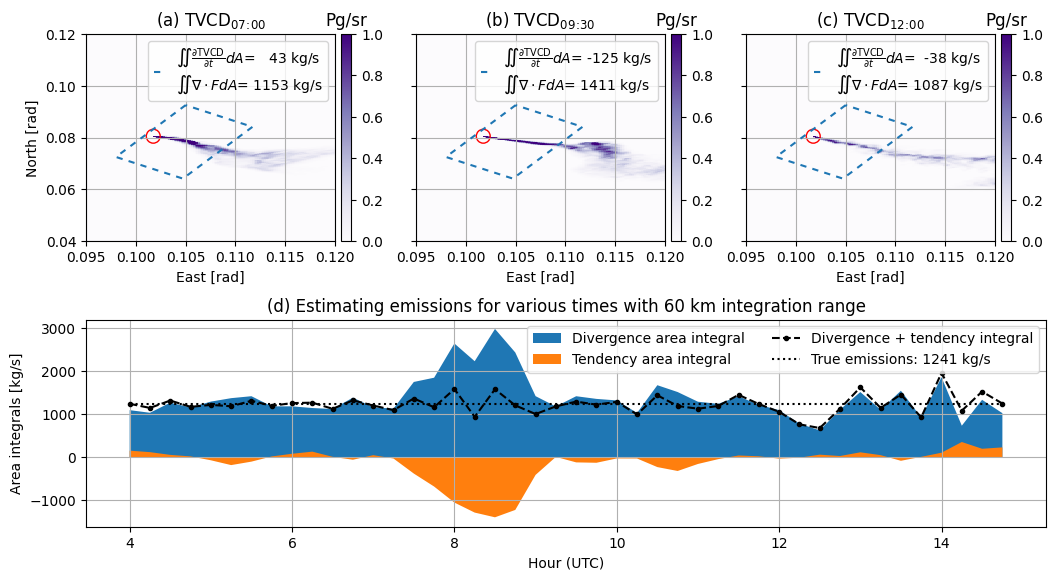

In [4]:
import gc
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d # Different interface to the same function
from scipy.interpolate import splprep, splev, interp2d, NearestNDInterpolator, LinearNDInterpolator
from matplotlib.path import Path
from collections import Counter
from matplotlib.colors import TwoSlopeNorm
from datetime import datetime, timedelta


x = np.deg2rad(TVCD.rlon.values)
y = np.deg2rad(TVCD.rlat.values)
XX, YY = np.meshgrid(x, y)
X, Y = np.meshgrid(x+0.00017453/2, y+0.00017453/2)

fig = plt.figure(figsize=(10*1,4*1.4))

# Set top axes
left = 0.02
bottom = 0.53
width = 0.3
height = 0.37
ax0 = fig.add_axes([left, bottom, width, height])

left += width + 0.03
ax1 = fig.add_axes([left, bottom, width, height])
ax1.set_yticklabels([])

left += width + 0.03
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_yticklabels([])

# left = 1-0.015
# axcbar = fig.add_axes([left, bottom, 0.015, height]).axis('off')

# Set bottom axes
left = 0.02
bottom = 0.02
width = 0.3
height = 0.37

width = 1-0.02-left
axbottom = fig.add_axes([left, bottom, width, height])

# Figure 1: TVCD
d0 = ax0.pcolor(X, Y, TVCD.isel(time=12)/1e12, cmap='Purples', vmax=1, rasterized=True )
ax0.grid()
ax0.set_title('(a) TVCD$_\mathrm{07\!{:}\!00}$')
cb = fig.colorbar(d0, ax=ax0, pad=0.02)
cb.ax.set_title('Pg/sr')
ax0.set_xlabel('East [rad]')
ax0.set_ylabel('North [rad]')
ax0.set_xlim([0.095, 0.12])
ax0.set_ylim([0.04, 0.12])
ax0.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 2
d1 = ax1.pcolor(X, Y, TVCD.isel(time=22)/1e12, vmin=0, vmax=1, cmap='Purples', rasterized=True )
ax1.grid()
ax1.set_title('(b) TVCD$_\mathrm{09\!{:}\!30}$')
cb = fig.colorbar(d1, ax=ax1, pad=0.02)
cb.ax.set_title('Pg/sr')
ax1.set_xlabel('East [rad]')
# ax1.set_ylabel('North [rad]')
ax1.set_xlim([0.095, 0.12])
ax1.set_ylim([0.04, 0.12])
ax1.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 3
d1 = ax2.pcolor(X, Y, TVCD.isel(time=32)/1e12, vmin=0, vmax=1, cmap='Purples', rasterized=True )
ax2.grid()
ax2.set_title('(c) TVCD$_\mathrm{12\!{:}\!00}$')
cb = fig.colorbar(d1, ax=ax2, pad=0.02)
cb.ax.set_title('Pg/sr')
ax2.set_xlabel('East [rad]')
# ax2.set_ylabel('North [rad]')
ax2.set_xlim([0.095, 0.12])
ax2.set_ylim([0.04, 0.12])
ax2.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')


pt1 = np.asarray([0.105,0.0925]) 
pt2 = np.asarray([0.098,0.0725])
vecX = np.asarray([0.01, -0.0125])
vecY = np.asarray([0.007, +0.02])

for scalar in [scv[20],][::-1]:
    pts=np.asarray([
        pt1,
        pt2,
        pt2+scalar*vecX,
        pt2+scalar*vecX+vecY,
        pt2+vecY
    ])
    x_line, y_line = return_closed_curve(pts, npts=1000, k=1)
    line0, = ax0.plot(x_line, y_line, '--', dashes=(3,3), label=r'$\iint \frac{{\partial \mathrm{{TVCD}} }}{{\partial t}} dA$={:5.0f} kg/s' "\n" r'$\iint \nabla \cdot F dA$={:5.0f} kg/s'.format(np.asarray(res_TMP)[12,20],np.asarray(res_DIV)[12,20]))
    line1, = ax1.plot(x_line, y_line, '--', dashes=(3,3), label=r'$\iint \frac{{\partial \mathrm{{TVCD}} }}{{\partial t}} dA$={:5.0f} kg/s' "\n" r'$\iint \nabla \cdot F dA$={:5.0f} kg/s'.format(np.asarray(res_TMP)[22,20],np.asarray(res_DIV)[22,20]))
    line2, = ax2.plot(x_line, y_line, '--', dashes=(3,3), label=r'$\iint \frac{{\partial \mathrm{{TVCD}} }}{{\partial t}} dA$={:5.0f} kg/s' "\n" r'$\iint \nabla \cdot F dA$={:5.0f} kg/s'.format(np.asarray(res_TMP)[32,20],np.asarray(res_DIV)[32,20]))
ax0.legend(handlelength=0.8)
ax1.legend(handlelength=0.8)
ax2.legend(handlelength=0.8)

t = np.arange(datetime(2018,6,5,4,0), datetime(2018,6,5,15,0), timedelta(hours=0.25)).astype(datetime)
t = [item.hour + item.minute/60 for item in t]
Y = np.arange(44)
Z = np.asarray(res_DIV)[:-1,20]
tmp = np.asarray(res_TMP)[:-1,20]
axbottom.fill_between(t, Z, label='Divergence area integral')
axbottom.fill_between(t, tmp, 0, label='Tendency area integral')
axbottom.plot(t, Z+tmp, 'k--.', label='Divergence + tendency integral')
axbottom.plot(t, Z*0+1241, 'k:', label='True emissions: 1241 kg/s')
plt.gcf().autofmt_xdate()
axbottom.set_xlabel('Hour (UTC)')
axbottom.set_ylabel('Area integrals [kg/s]')
axbottom.set_title('(d) Estimating emissions for various times with 60 km integration range')
axbottom.grid()
axbottom.legend(ncol=2)

plt.savefig('emissions_along_plume_3panels.pdf', dpi=300, bbox_inches='tight')

gc.collect()
print('finished')

In [5]:
(scv[20]-0.08)*6371*np.linalg.norm(vecX) # offset in km

60.31729310681234

In [6]:
(Z + tmp).mean(), Z.mean() # div+tendency, just div

(1223.0907407259313, 1369.3354771531372)

# Figure 10

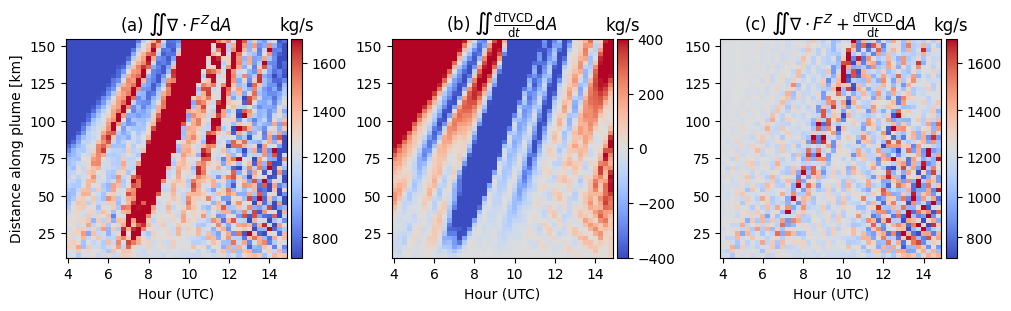

In [7]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.dates as dates
from matplotlib import colors
import matplotlib.ticker as ticker
import numpy as np
from datetime import datetime, timedelta
from matplotlib.ticker import MaxNLocator, FuncFormatter

divnorm=colors.TwoSlopeNorm(vmin=700, vcenter=1241, vmax=1700)
divnorm2=colors.TwoSlopeNorm(vmin=-400, vcenter=0, vmax=400)

t = np.arange(datetime(2018,6,5,4,0), datetime(2018,6,5,15,0), timedelta(hours=0.25)).astype(datetime)
t = [item.hour + item.minute/60 for item in t]

fig = plt.figure(figsize=(10*1,3*1), layout="constrained")

# gs = fig.add_gridspec(1,3)
# ax0 = fig.add_subplot(gs[0])
# ax1 = fig.add_subplot(gs[1])
# ax2 = fig.add_subplot(gs[2])
ax_dict = fig.subplot_mosaic(
    """
    ABC
    """)
ax0 = ax_dict['A']
ax1 = ax_dict['B']
ax2 = ax_dict['C']


# Make data.
Y = scv*np.linalg.norm(vecX)*6371
X = t
X, Y = np.meshgrid(X, Y)
Z = np.asarray(res_DIV)[:-1,:]

# --- Fig 1
surf = ax0.pcolormesh(X, Y, Z.T, cmap=cm.coolwarm, norm=divnorm,
                       linewidth=5, antialiased=True)
ax0.set_ylabel('Distance along plume [km]')
ax0.set_xlabel('Hour (UTC)')
ax0.set_title(r'(a) $\iint \nabla \cdot  F^Z \mathrm{d}A$')
# plt.gcf().autofmt_xdate()
cb = fig.colorbar(surf, ax=ax0, pad=0.02)
cb.ax.set_title('kg/s')

# --- Fig 2
Z = np.asarray(res_TMP)[:-1,:]
surf = ax1.pcolormesh(X, Y, Z.T, cmap=cm.coolwarm, norm=divnorm2,
                       linewidth=5, antialiased=True)
ax1.set_xlabel('Hour (UTC)')
ax1.set_title(r'(b) $\iint \frac{{ \mathrm{{dTVCD}} }}{{ \mathrm{{d}}t }} \mathrm{d}A$')
cb = fig.colorbar(surf, ax=ax1, pad=0.02)
cb.ax.set_title('kg/s')


# --- Fig 3
Z = np.asarray(res_DIV)[:-1,:] + np.asarray(res_TMP)[:-1,:]
surf = ax2.pcolormesh(X, Y, Z.T, cmap=cm.coolwarm, norm=divnorm,
                       linewidth=5, antialiased=True)
ax2.set_xlabel('Hour (UTC)')
ax2.set_title(r'(c) $\iint \nabla \cdot  F^Z + \frac{{ \mathrm{{dTVCD}} }}{{ \mathrm{{d}}t }} \mathrm{d}A$')
cb = fig.colorbar(surf, ax=ax2, pad=0.02)
cb.ax.set_title('kg/s')

# plt.setp(ax0.get_xticklabels(), rotation=45, ha='right')
# plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
# plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{int(x)}"))

plt.savefig('all_temporal_profiles.pdf', dpi=300, bbox_inches='tight')

# Figure 11

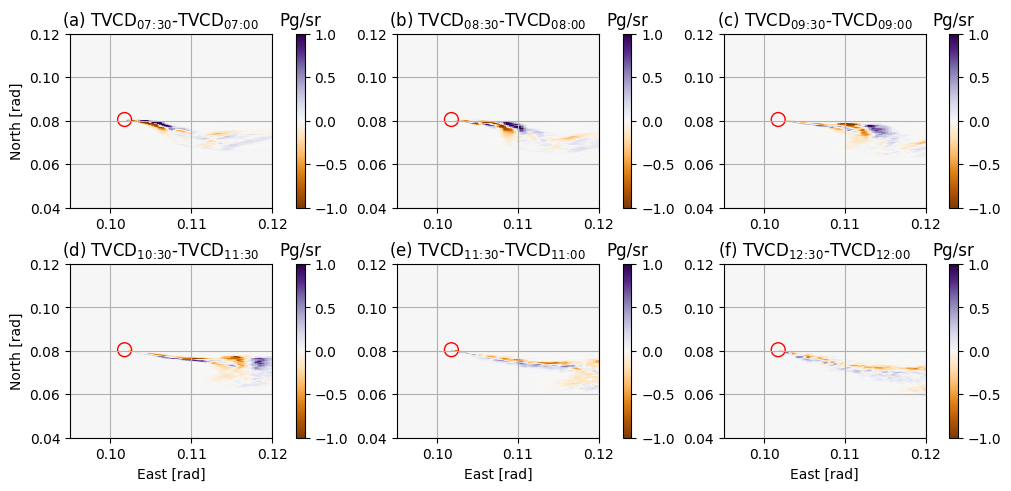

In [8]:
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d # Different interface to the same function
from scipy.interpolate import splprep, splev, interp2d, NearestNDInterpolator, LinearNDInterpolator
from matplotlib.path import Path
from collections import Counter
from matplotlib.colors import TwoSlopeNorm

x = np.deg2rad(TVCD.rlon.values)
y = np.deg2rad(TVCD.rlat.values)
XX, YY = np.meshgrid(x, y)
X, Y = np.meshgrid(x+0.00017453/2, y+0.00017453/2)

fig = plt.figure(figsize=(10*1.,4*1.2), layout="constrained")

gs0 = fig.add_gridspec(2,3)
ax0 = fig.add_subplot(gs0[0, 0])
ax1 = fig.add_subplot(gs0[0, 1])
ax2 = fig.add_subplot(gs0[0, 2])
ax3 = fig.add_subplot(gs0[1, 0])

ax4 = fig.add_subplot(gs0[1, 1])
ax5 = fig.add_subplot(gs0[1, 2])

# Figure 1: TVCD
d0 = ax0.pcolor(X, Y, TVCD.isel(time=14)/1e12-TVCD.isel(time=12)/1e12, cmap='PuOr', vmin=-1, vmax=1, rasterized=True )
ax0.grid()
ax0.set_title('(a) TVCD$_\mathrm{07\!{:}\!30}$-TVCD$_\mathrm{07\!{:}\!00}$', x=0.45)
cb = fig.colorbar(d0, ax=ax0, pad=0.02)
cb.ax.set_title('Pg/sr')
# ax0.set_xlabel('East [rad]')
ax0.set_ylabel('North [rad]')
ax0.set_xlim([0.095, 0.12])
ax0.set_ylim([0.04, 0.12])
ax0.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 2
d1 = ax1.pcolor(X, Y, TVCD.isel(time=18)/1e12-TVCD.isel(time=16)/1e12, vmin=-1, vmax=1, cmap='PuOr', rasterized=True )
ax1.grid()
ax1.set_title('(b) TVCD$_\mathrm{08\!{:}\!30}$-TVCD$_\mathrm{08\!{:}\!00}$', x=0.45)
cb = fig.colorbar(d1, ax=ax1, pad=0.02)
cb.ax.set_title('Pg/sr')
# ax1.set_xlabel('East [rad]')
# ax1.set_ylabel('North [rad]')
ax1.set_xlim([0.095, 0.12])
ax1.set_ylim([0.04, 0.12])
ax1.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 3
d1 = ax2.pcolor(X, Y, TVCD.isel(time=22)/1e12-TVCD.isel(time=20)/1e12, vmin=-1, vmax=1, cmap='PuOr', rasterized=True )
ax2.grid()
ax2.set_title('(c) TVCD$_\mathrm{09\!{:}\!30}$-TVCD$_\mathrm{09\!{:}\!00}$', x=0.45)
cb = fig.colorbar(d1, ax=ax2, pad=0.02)
cb.ax.set_title('Pg/sr')
# ax2.set_xlabel('East [rad]')
# ax2.set_ylabel('North [rad]')
ax2.set_xlim([0.095, 0.12])
ax2.set_ylim([0.04, 0.12])
ax2.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 4
d1 = ax3.pcolor(X, Y, TVCD.isel(time=26)/1e12-TVCD.isel(time=24)/1e12, vmin=-1, vmax=1, cmap='PuOr', rasterized=True )
ax3.grid()
ax3.set_title('(d) TVCD$_\mathrm{10\!{:}\!30}$-TVCD$_\mathrm{11\!{:}\!30}$', x=0.45)
cb = fig.colorbar(d1, ax=ax3, pad=0.02)
cb.ax.set_title('Pg/sr')
ax3.set_xlabel('East [rad]')
ax3.set_ylabel('North [rad]')
ax3.set_xlim([0.095, 0.12])
ax3.set_ylim([0.04, 0.12])
ax3.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 5
d1 = ax4.pcolor(X, Y, TVCD.isel(time=30)/1e12-TVCD.isel(time=28)/1e12, vmin=-1, vmax=1, cmap='PuOr', rasterized=True )
ax4.grid()
ax4.set_title('(e) TVCD$_\mathrm{11\!{:}\!30}$-TVCD$_\mathrm{11\!{:}\!00}$', x=0.45)
cb = fig.colorbar(d1, ax=ax4, pad=0.02)
cb.ax.set_title('Pg/sr')
ax4.set_xlabel('East [rad]')
# ax4.set_ylabel('North [rad]')
ax4.set_xlim([0.095, 0.12])
ax4.set_ylim([0.04, 0.12])
ax4.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

# Figure 6
d1 = ax5.pcolor(X, Y, TVCD.isel(time=34)/1e12-TVCD.isel(time=32)/1e12, vmin=-1, vmax=1, cmap='PuOr', rasterized=True )
ax5.grid()
ax5.set_title('(f) TVCD$_\mathrm{12\!{:}\!30}$-TVCD$_\mathrm{12\!{:}\!00}$', x=0.45)
cb = fig.colorbar(d1, ax=ax5, pad=0.02)
cb.ax.set_title('Pg/sr')
ax5.set_xlabel('East [rad]')
# ax3.set_ylabel('North [rad]')
ax5.set_xlim([0.095, 0.12])
ax5.set_ylim([0.04, 0.12])
ax5.scatter( 0.10175, 0.0805, s=100, facecolors='none', edgecolors='r')

plt.savefig('non_steady_state.pdf', dpi=300, bbox_inches='tight')
